In [1]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot

In [2]:
df = pd.read_excel('Data/all_data.xlsx')

In [3]:
df

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2023-03-01,23150.929688,23880.632813,23088.626953,23646.550781,24662841200,positif,43,23646.550781
1,2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,20386398516,negatif,45,23475.466797
2,2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,26062404610,negatif,52,22362.679688
3,2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,11166012913,negatif,40,22353.349609
4,2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,13317001733,negatif,38,22435.513672
...,...,...,...,...,...,...,...,...,...
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063


# PREPROCESSING

In [4]:
df = df.drop(columns=['Date'])

In [5]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
df['Sentimen'] = df['Sentimen'].map(sentimen_mapping)

In [6]:
X = df.drop('Close', axis=1)
y = df['Close']

In [7]:
X, y, scaler = scale_data(df)

In [8]:
X

array([[[0.07002981, 0.08061168, 0.08466681, ..., 0.24813463,
         1.        , 0.2962963 ]],

       [[0.08175457, 0.07736212, 0.0884934 , ..., 0.19324368,
         0.        , 0.32098765]],

       [[0.07772759, 0.07139575, 0.06324821, ..., 0.26609894,
         0.        , 0.40740741]],

       ...,

       [[0.74549014, 0.79388071, 0.76590194, ..., 0.3689383 ,
         1.        , 0.24691358]],

       [[0.81140218, 0.85358472, 0.85283922, ..., 0.57023243,
         1.        , 0.5308642 ]],

       [[0.87171075, 1.        , 0.9079946 , ..., 1.        ,
         1.        , 1.        ]]])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        elif n_lstm == 3:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history 
    except Exception as e:
        print(f"Error during model training: {e}")
        return None 

def tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs):
    results = {} 

    for n_lstm in lstm_configs['n_lstm']:
        for neuron in lstm_configs['neurons']:
            for epoch in lstm_configs['epochs']:
                print(f'Running trial with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                key = f'n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}'
                history = declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test)
                
                if history is not None:
                    mse_train = history.history['loss'][-1]  
                    mse_test = history.history['val_loss'][-1] 
                    results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                else:
                    print(f"Skipping combination n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

lstm_configs = {
    'n_lstm': [1, 2, 3], 
    'neurons': [50, 100, 150, 200],  
    'epochs': [10, 20, 30] 
}

In [11]:
results = tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs)

Running trial with n_lstm=1, neuron=50, epoch=10
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 292 samples, validate on 73 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
292/292 [==============================] - 0s 2ms/sample - loss: 0.0399 - val_loss: 0.1298
Epoch 2/10
292/292 [==============================] - 0s 78us/sample - loss: 0.0173 - val_loss: 0.0714
Epoch 3/10
292/292 [==============================] - 0s 73us/sample - loss: 0.0148 - val_loss: 0.1320
Epoch 4/10
292/292 [==============================] - 0s 85us/sample - loss: 0.0140 - val_loss: 0.1391
Epoch 5/10
292/292 [==============================] - 0s 58us/sample - loss: 0.0134 - val_loss: 0.1122
Epoch 6/10
292/292 [==============================] - 0s 89us/sample - loss: 0.0132 - val_loss: 0.1177
Epoch 7/10
292/292 [==============================] - 0s 62us/sample - loss: 0.0130 - val_loss: 0.1355
Epoch 8/10
292/292 [==============================] - 0s 73us/sample - loss: 0.0130 - val_loss: 0.1281
Epoch 9/10
292/292 [==================

In [12]:
hasil = []

for key, value in results.items():
    mse_train = value['mse_train']
    mse_test = value['mse_test']
    hasil.append({
        'experiment': key,
        'mse_train': mse_train,
        'mse_test': mse_test
    })

hp_lstm = pd.DataFrame(hasil)

for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")

Experiment: n_lstm=1_neurons=50_epochs=10, MSE Train: 0.01267298724349231, MSE Test: 0.13450826183982093
Experiment: n_lstm=1_neurons=50_epochs=20, MSE Train: 0.012472636308776189, MSE Test: 0.14760250240972597
Experiment: n_lstm=1_neurons=50_epochs=30, MSE Train: 0.012483943783206074, MSE Test: 0.14610033604788453
Experiment: n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012680900729682348, MSE Test: 0.13492421213894673
Experiment: n_lstm=1_neurons=100_epochs=20, MSE Train: 0.012532139834884095, MSE Test: 0.1426348017707263
Experiment: n_lstm=1_neurons=100_epochs=30, MSE Train: 0.012477662057092744, MSE Test: 0.13404237570827954
Experiment: n_lstm=1_neurons=150_epochs=10, MSE Train: 0.012686045189732558, MSE Test: 0.12358480508196844
Experiment: n_lstm=1_neurons=150_epochs=20, MSE Train: 0.012330740549895044, MSE Test: 0.1457192188460533
Experiment: n_lstm=1_neurons=150_epochs=30, MSE Train: 0.01253021587553906, MSE Test: 0.1354191316521331
Experiment: n_lstm=1_neurons=200_epochs=10, M

In [13]:
hp_lstm

,experiment,mse_train,mse_test
0,n_lstm=1_neurons=50_epochs=10,0.012673,0.134508
1,n_lstm=1_neurons=50_epochs=20,0.012473,0.147603
2,n_lstm=1_neurons=50_epochs=30,0.012484,0.146100
3,n_lstm=1_neurons=100_epochs=10,0.012681,0.134924
4,n_lstm=1_neurons=100_epochs=20,0.012532,0.142635
5,n_lstm=1_neurons=100_epochs=30,0.012478,0.134042
6,n_lstm=1_neurons=150_epochs=10,0.012686,0.123585
7,n_lstm=1_neurons=150_epochs=20,0.012331,0.145719
8,n_lstm=1_neurons=150_epochs=30,0.012530,0.135419
9,n_lstm=1_neurons=200_epochs=10,0.012531,0.143655


In [14]:
hp_lstm.to_excel("kombinasi-parameter.xlsx")

In [15]:
max_mse_train_index = hp_lstm['mse_train'].idxmin()
max_mse_train_row = hp_lstm.loc[max_mse_train_index]
print(max_mse_train_row)

experiment    n_lstm=2_neurons=100_epochs=30
mse_train                           0.000282
mse_test                             0.00143
Name: 17, dtype: object


In [16]:
max_mse_test_index = hp_lstm['mse_test'].idxmin()
max_mse_test_row = hp_lstm.loc[max_mse_test_index]
print(max_mse_test_row)

experiment    n_lstm=2_neurons=150_epochs=30
mse_train                           0.000319
mse_test                            0.000953
Name: 20, dtype: object


In [37]:
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=150))
model.add(Dense(25))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))

Train on 292 samples, validate on 73 samples
Epoch 1/30
292/292 [==============================] - 6s 19ms/sample - loss: 0.0305 - val_loss: 0.0746
Epoch 2/30
292/292 [==============================] - 0s 524us/sample - loss: 0.0114 - val_loss: 0.0698
Epoch 3/30
292/292 [==============================] - 0s 528us/sample - loss: 0.0057 - val_loss: 0.0655
Epoch 4/30
292/292 [==============================] - 0s 490us/sample - loss: 0.0039 - val_loss: 0.0240
Epoch 5/30
292/292 [==============================] - 0s 502us/sample - loss: 0.0020 - val_loss: 0.0096
Epoch 6/30
292/292 [==============================] - 0s 534us/sample - loss: 8.2249e-04 - val_loss: 0.0010
Epoch 7/30
292/292 [==============================] - 0s 513us/sample - loss: 4.9249e-04 - val_loss: 0.0013
Epoch 8/30
292/292 [==============================] - 0s 501us/sample - loss: 4.2348e-04 - val_loss: 0.0013
Epoch 9/30
292/292 [==============================] - 0s 507us/sample - loss: 3.2253e-04 - val_loss: 9.3419e-04


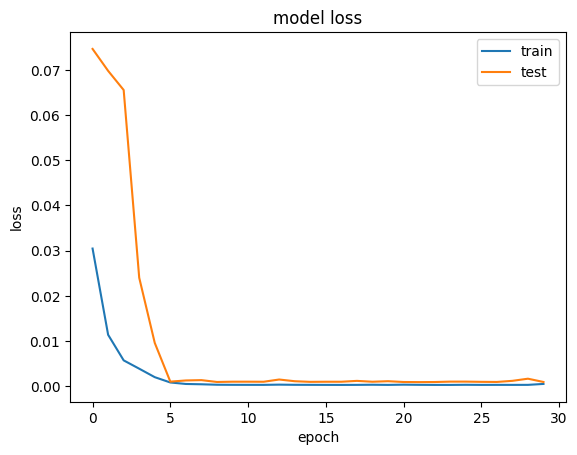

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [39]:
predictions_train = model.predict(X_train)

inverse_predictions_train = inverse_transform(scaler, predictions_train)
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

,Predicted,Actual
0,23807.122103,23475.466797
1,23639.674589,22362.679688
2,23049.468212,22353.349609
3,22451.752724,22435.513672
4,22572.490142,22429.757813


In [40]:
predictions_test = model.predict(X_test)

inverse_predictions_test = inverse_transform(scaler, predictions_test)
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.tail()

,Predicted,Actual
68,52380.641638,51733.238281
69,52905.920288,54522.402344
70,54857.748723,57085.371094
71,58250.476434,62504.789063
72,63418.792881,61198.382813


# METRIKS EVALUASI

In [41]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 707.4347572602925
Root Mean Squared Error (RMSE) Test Set: 1292.9704691745494

R-squared Train Set: 0.9772722149921015
R-squared Test Set: 0.9290363790512574


# VISUALISASI

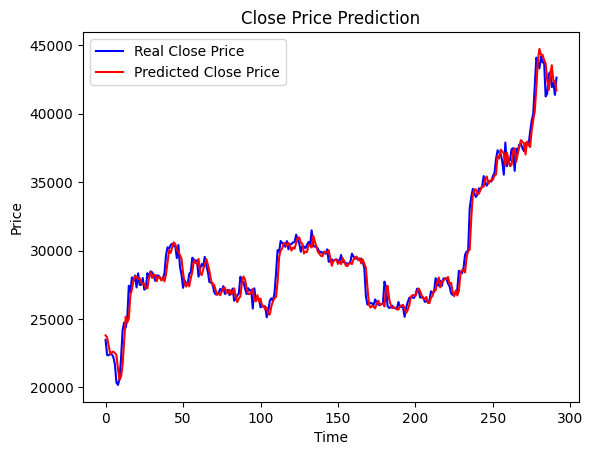

In [42]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)


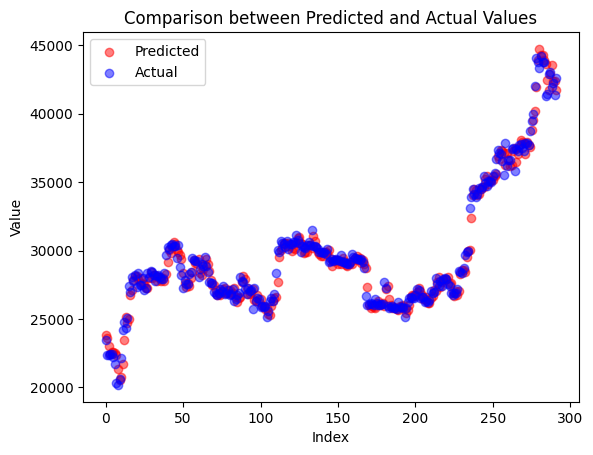

In [43]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)


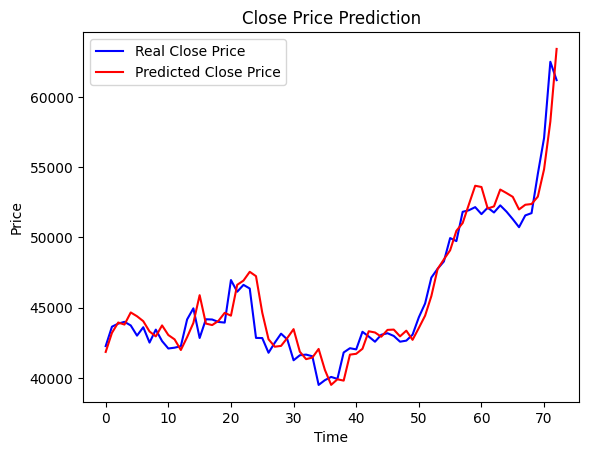

In [44]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

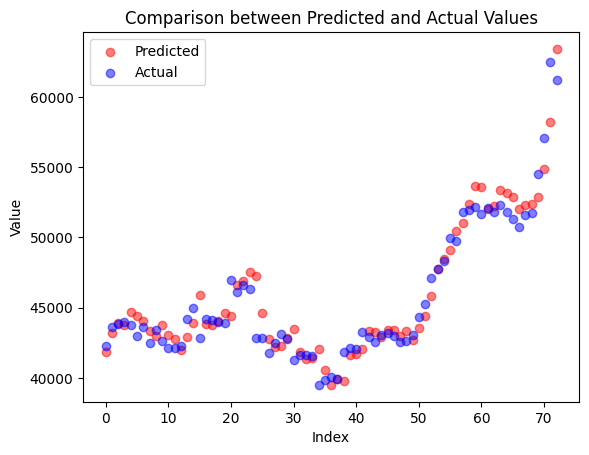

In [45]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [46]:
features = ["Open", "High", "Low", "Adj_Close", "Volume", "Sentimen", "Index"]

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

# TEST DENGAN DATA BARU

In [47]:
dt = pd.read_excel('Data/all_data_validation.xlsx')
dt

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2024-03-01,61168.062500,63155.101563,60802.527344,62440.632813,40186368423,positif,59,62440.632813
1,2024-03-02,62431.652344,62458.699219,61657.289063,62029.847656,23888473685,positif,46,62029.847656
2,2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094,26253811450,positif,44,63167.371094
3,2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063,70670471105,positif,81,68330.414063
4,2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219,102802940877,positif,100,63801.199219
5,2024-03-06,63776.050781,67637.929688,62848.671875,66106.804688,68750229073,positif,78,66106.804688
6,2024-03-07,66099.742188,68029.921875,65655.531250,66925.484375,46989543159,positif,62,66925.484375
7,2024-03-08,66938.093750,70083.054688,66230.453125,68300.093750,59202881172,positif,63,68300.093750
8,2024-03-09,68299.257813,68673.054688,68053.125000,68498.882813,21609650379,positif,52,68498.882813
9,2024-03-10,68500.257813,70005.203125,68239.976563,69019.789063,35683977532,negatif,56,69019.789063


In [48]:
dt = dt.drop(columns=["Date"])

In [49]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
dt['Sentimen'] = dt['Sentimen'].map(sentimen_mapping)

In [50]:
dt.describe()

,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
count,31.000000,31.000000,31.000000,31.000000,3.100000e+01,31.000000,31.000000,31.000000
mean,67372.752394,69272.725933,65532.276714,67702.439264,4.665864e+10,0.548387,56.419355,67702.439264
std,3292.243235,2911.385403,3273.325051,3157.882425,2.025387e+10,0.809885,15.751771,3157.882425
min,61168.062500,62458.699219,59323.910156,61912.773438,1.713024e+10,-1.000000,35.000000,61912.773438
25%,64693.548828,68068.425782,62617.595703,65403.253907,3.079077e+10,0.500000,45.500000,65403.253907
50%,68299.257813,69170.625000,65655.531250,68330.414063,4.448035e+10,1.000000,52.000000,68330.414063
75%,69770.613282,71456.761719,68472.476563,69925.820312,6.107452e+10,1.000000,63.000000,69925.820312
max,73079.375000,73750.070313,71334.093750,73083.500000,1.028029e+11,1.000000,100.000000,73083.500000


In [51]:
X_ = dt.drop(columns=['Close'])
y_ = dt['Close']

In [52]:
X, y, scalers = scale_data(dt)

In [53]:
predictions = model.predict(X) 

inverse_predictions_new = inverse_transform(scalers, predictions)
y_test_original_new = inverse_transform(scalers, y)

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_new.flatten(), 'Actual': y_test_original_new.flatten()})
compare_model_test

,Predicted,Actual
0,62625.790796,62029.847656
1,62766.460272,63167.371094
2,63141.532380,68330.414063
3,66480.014705,63801.199219
4,65892.023048,66106.804688
5,65845.022307,66925.484375
6,67297.645166,68300.093750
7,68634.772976,68498.882813
8,68903.258468,69019.789063
9,69343.354260,72123.906250


In [54]:
mse_model_newdata = mean_squared_error(y_test_original_new, inverse_predictions_new)
rmse_model_newdata = np.sqrt(mse_model_newdata)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_newdata)
print("======================================================")

# Menghitung R-square
r2_xgb_test = r2_score(y_test_original_new, inverse_predictions_new)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Test Set: 2382.9521932063567
R-squared Test Set: 0.3703591433298794


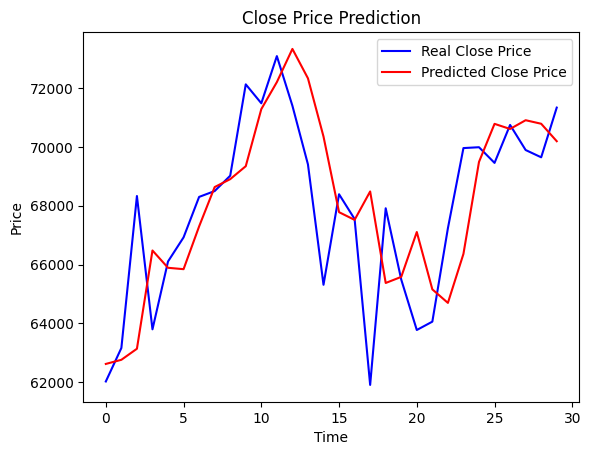

In [55]:
lineplot(y_test_original_new, inverse_predictions_new)

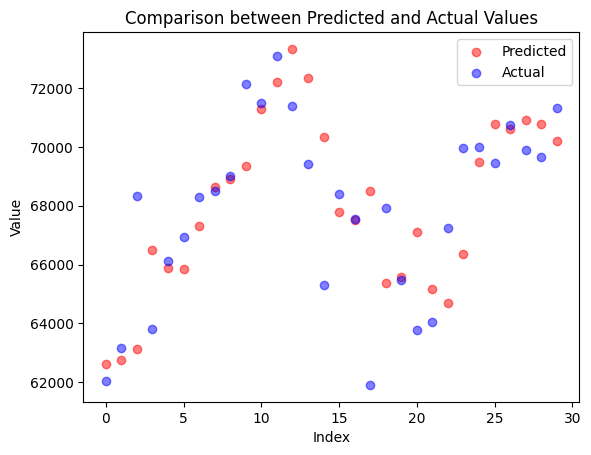

In [56]:
scatterplot(y_test_original_new, inverse_predictions_new)